In [1]:
import cantata
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cantata.plotting import output as cp
from cantata import cfg

In [2]:
%load_ext autoreload
%autoreload 1
%aimport cantata, cantata.plotting.output

In [3]:
figsize = (14,5)

In [4]:
cfg.batch_size = 1
cfg.model.weight_scale = .5
cfg.model.w_mean = 400e-3
cfg.model.populations.E23.noise_weight = 3e-3
cfg.model.populations.I23.noise_weight = 3e-3
cfg.model.populations.E23.targets.E23.A_p = 0.5
cfg.model.populations.E23.targets.E23.A_d = 0.1
# cfg.model.populations.E23.p

# cfg.model.populations.Thal.n = 2
# cfg.model.populations.Thal.targets.E23.density = .5
# cfg.model.populations.Thal.targets.I23.density = .25

In [5]:
second = int(1/cfg.time_step)

In [6]:
cfg.n_steps = int(5 * second)
rate_0, rate_1 = 0, 50 # Hz
t_on, t_off = .15*second, .15*second

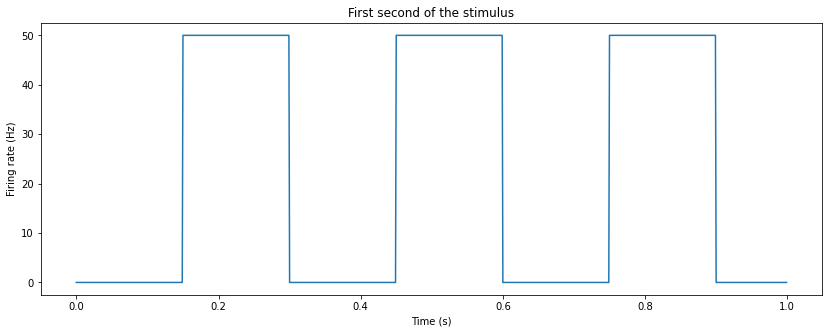

In [7]:
inputs = torch.where(torch.arange(cfg.n_steps)%(t_on+t_off) >= t_off, rate_1, rate_0)

plt.figure(figsize=figsize)
plt.plot(np.arange(second) * cfg.time_step, inputs[:second])
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.title('First second of the stimulus')

inputs = inputs.reshape(1,-1,1).expand(cfg.batch_size, -1, cfg.n_inputs)

In [8]:
m = cantata.Module()
with torch.no_grad():
    record = m.forward(inputs, ['w_stdp'])

In [9]:
batch = 0

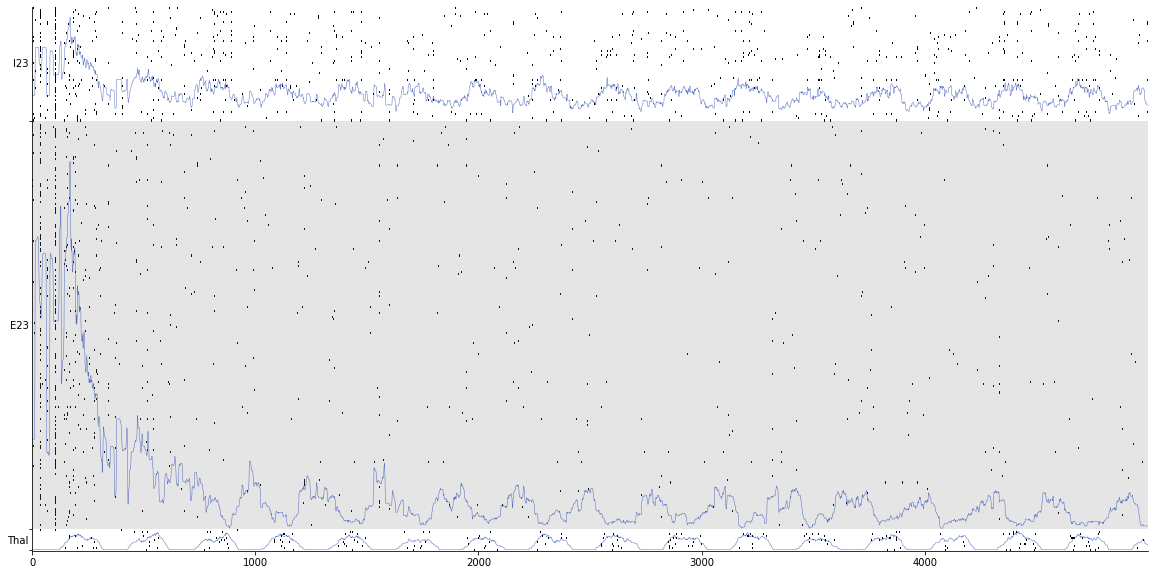

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
spikes = record.out[batch:batch+1,0:5000]
cp.raster(spikes, ax, rates=cp.get_rates(spikes, kwidth=50), c='#1133AAAA', lw=0.5);

Mean firing rates:
Thal: 18.7 Hz
E23: 3.1 Hz
I23: 12.1 Hz


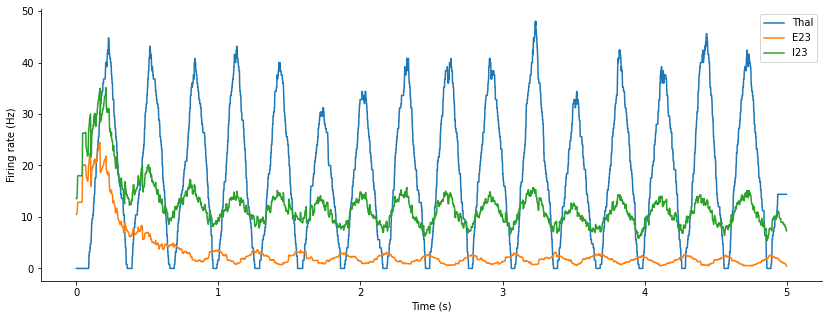

In [11]:
rates = cp.get_rates(record.out, kwidth=125)
t = np.arange(cfg.n_steps) / second
plt.figure(figsize=figsize)
print('Mean firing rates:')
for i,p in enumerate(cfg.model.populations.keys()):
    plt.plot(t, rates[batch,i].cpu(), label=p)
    mean = rates[batch,i].mean().item()
    print(f'{p}: {mean:.1f} Hz')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')
plt.legend()
sns.despine()

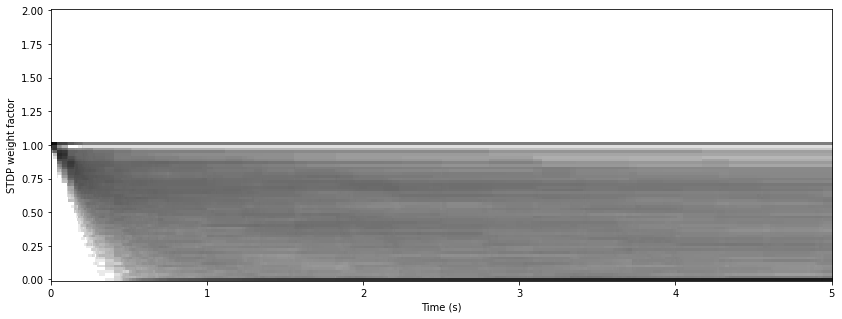

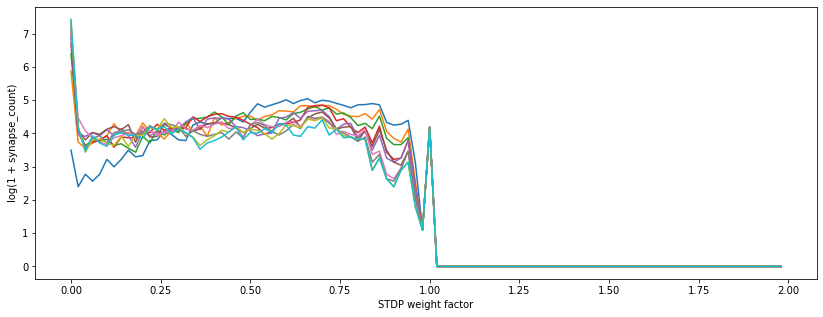

In [12]:
ticks, _,_ = cp.get_ticks()
mask = m.w != 0
mask[:ticks[1]] = False
mask[ticks[2]:] = False
mask[:,:ticks[1]] = False
mask[:,ticks[2]:] = False
w = record.w_stdp[batch]
n_bins = 100
bins = np.arange(0,2,2/n_bins)
w_hist = np.empty((cfg.n_steps, n_bins))
for i in range(cfg.n_steps):
    w_hist[i] = np.log(1 + torch.histc(w[i][mask], n_bins, 0, 2).cpu())
plt.figure(figsize=figsize)
plt.imshow(w_hist.T, cmap=plt.cm.gray_r, origin='lower', aspect='auto', interpolation='none',
          extent=(-.5/second, (cfg.n_steps+.5)/second, -.5/(n_bins/2), (n_bins+.5)/(n_bins/2)))
plt.xlabel('Time (s)')
plt.ylabel('STDP weight factor')
plt.figure(figsize=figsize)
for i in range(499, cfg.n_steps, 500):
    plt.plot(bins, w_hist[i], label=f'{i}')
plt.xlabel('STDP weight factor')
plt.ylabel('log(1 + synapse_count)');

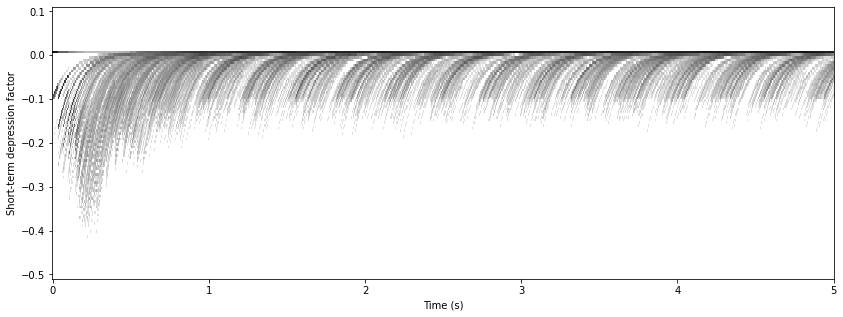

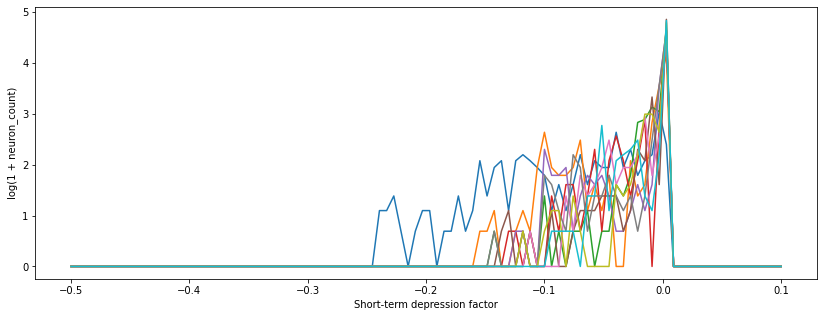

In [30]:
wp = record.w_p[batch, :, ticks[1]:ticks[2]]
wp_hist = np.empty((cfg.n_steps, n_bins))
bins = np.linspace(-.5,0.1,n_bins)
for i in range(cfg.n_steps):
    wp_hist[i] = np.log(1 + torch.histc(wp[i], n_bins, bins[0], bins[-1]).cpu())
plt.figure(figsize=figsize)
plt.imshow(wp_hist.T, cmap=plt.cm.gray_r, origin='lower', aspect='auto', interpolation='none',
          extent=(-.5/second, (cfg.n_steps+.5)/second, bins[0] - .5/(n_bins/2), bins[-1] + .5/(n_bins/2)))
plt.xlabel('Time (s)')
plt.ylabel('Short-term depression factor')
plt.figure(figsize=figsize)
for i in range(499, cfg.n_steps, 500):
    plt.plot(bins, wp_hist[i], label=f'{i}')
plt.xlabel('Short-term depression factor')
plt.ylabel('log(1 + neuron_count)');